In [2]:
# Install required libraries
!pip install matplotlib numpy --upgrade

print("Libraries installed successfully!")


Libraries installed successfully!


In [7]:
# ─────────────────────────────────────────────
# SCENARIO GRIDS
# ─────────────────────────────────────────────

def create_best_case_grid():
    """
    Best case: target is very close to start, open path.
    Good for BFS, UCS, Bidirectional — found in very few steps.
    DFS gets lucky because the direct direction is explored first.
    IDDFS finds it at depth 2-3 immediately.
    DLS finds it well within any reasonable limit.
    """
    env = GridEnvironment(10, 10)
    env.set_start((0, 0))
    env.set_target((1, 1))   # ← just 1 diagonal step away
    # No walls — completely open path
    return env


def create_worst_case_grid():
    """
    Worst case: target is in opposite corner, walls force a long
    snaking detour. Every algorithm struggles here:
    - BFS/UCS explore almost the whole grid
    - DFS dives deep into dead ends first
    - DLS hits its limit before reaching the target
    - IDDFS repeats many levels before finding deep path
    - Bidirectional wastes many steps before frontiers meet
    """
    env = GridEnvironment(10, 10)
    env.set_start((0, 0))
    env.set_target((9, 9))   # ← opposite corner

    # Horizontal wall blocking row 2, forcing detour right
    for c in range(0, 8):
        env.add_wall((2, c))

    # Vertical wall blocking col 8, forcing detour down
    for r in range(3, 8):
        env.add_wall((r, 8))

    # Horizontal wall blocking row 7, forcing detour left
    for c in range(2, 9):
        env.add_wall((7, c))

    # Vertical wall blocking col 2, forcing detour down again
    for r in range(3, 7):
        env.add_wall((r, 1))

    return env
    

In [9]:
"""
AI Pathfinder - All 6 Uninformed Search Algorithms

"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import deque
import heapq
import time

# ─────────────────────────────────────────────
# GRID ENVIRONMENT
# ─────────────────────────────────────────────
class GridEnvironment:
    def __init__(self, rows=6, cols=6):
        self.rows = rows
        self.cols = cols
        self.grid = np.zeros((rows, cols))
        self.start  = None
        self.target = None

    def set_start(self, pos):
        if self.start: self.grid[self.start] = 0
        self.start = pos
        self.grid[pos] = 2

    def set_target(self, pos):
        if self.target: self.grid[self.target] = 0
        self.target = pos
        self.grid[pos] = 3

    def add_wall(self, pos):
        if pos != self.start and pos != self.target:
            self.grid[pos] = 1

    def is_valid(self, pos):
        r, c = pos
        return (0 <= r < self.rows and
                0 <= c < self.cols and
                self.grid[r, c] != 1)

    def get_neighbors(self, pos):
        r, c = pos
        # ALL 8 directions clockwise 
        dirs = [
            (-1, 0),  # Up
            (-1, 1),  # Up-Right
            (0,  1),  # Right
            (1,  1),  # Down-Right
            (1,  0),  # Down
            (1, -1),  # Down-Left
            (0, -1),  # Left
            (-1,-1),  # Up-Left
        ]
        result = []
        for dr, dc in dirs:
            nb = (r+dr, c+dc)
            if self.is_valid(nb):
                cost = 1.4 if abs(dr)+abs(dc)==2 else 1.0
                result.append((nb, cost))
        return result

# ─────────────────────────────────────────────
# VISUALIZER
# ─────────────────────────────────────────────
class PathfinderVisualizer:
    def __init__(self, env):
        self.env   = env
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.exploration_order = {}
        self.frontier          = set()
        self.path              = []
        self.exploration_count = 0

    def setup_plot(self, title):
        self.ax.clear()
        self.ax.set_xlim(-0.5, self.env.cols - 0.5)
        self.ax.set_ylim(-0.5, self.env.rows - 0.5)
        self.ax.set_aspect('equal')
        self.ax.set_title(f"{title}\nGOOD PERFORMANCE TIME APP",
                          fontsize=13, fontweight='bold')
        self.ax.grid(True, alpha=0.3)
        self.ax.invert_yaxis()

    def add_explored(self, pos):
        if pos not in self.exploration_order and pos != self.env.start:
            self.exploration_count += 1
            self.exploration_order[pos] = self.exploration_count

    def draw_grid(self, extra_info=""):
        self.ax.clear()
        self.ax.set_xlim(-0.5, self.env.cols - 0.5)
        self.ax.set_ylim(-0.5, self.env.rows - 0.5)
        self.ax.set_aspect('equal')
        self.ax.grid(True, alpha=0.3)
        self.ax.invert_yaxis()

        # Static walls
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                if self.env.grid[r, c] == 1:
                    self.ax.add_patch(patches.Rectangle(
                        (c-.5, r-.5), 1, 1,
                        linewidth=1, edgecolor='black',
                        facecolor='black'))

        # Explored — numbered
        for pos, num in self.exploration_order.items():
            if pos not in (self.env.start, self.env.target):
                r, c = pos
                self.ax.add_patch(patches.Rectangle(
                    (c-.5, r-.5), 1, 1,
                    linewidth=1, edgecolor='steelblue',
                    facecolor='lightblue', alpha=0.7))
                self.ax.text(c, r, str(num), ha='center', va='center',
                             color='darkblue', fontsize=13, fontweight='bold')

        # Frontier — F
        for pos in self.frontier:
            if pos not in (self.env.start, self.env.target) \
               and pos not in self.exploration_order:
                r, c = pos
                self.ax.add_patch(patches.Rectangle(
                    (c-.5, r-.5), 1, 1,
                    linewidth=1, edgecolor='orange',
                    facecolor='yellow', alpha=0.7))
                self.ax.text(c, r, 'F', ha='center', va='center',
                             color='darkorange', fontsize=12, fontweight='bold')

        # Path line + numbered circles
        if len(self.path) > 1:
            xs = [c for r, c in self.path]
            ys = [r for r, c in self.path]
            self.ax.plot(xs, ys, 'g-', linewidth=5, alpha=0.8, zorder=3)
            for i, (r, c) in enumerate(self.path):
                if 0 < i < len(self.path)-1:
                    self.ax.add_patch(patches.Circle(
                        (c, r), 0.35, color='green', alpha=0.8, zorder=4))
                    self.ax.text(c, r, str(i), ha='center', va='center',
                                 color='white', fontsize=10,
                                 fontweight='bold', zorder=5)

        # Start
        if self.env.start:
            r, c = self.env.start
            self.ax.add_patch(patches.Circle((c,r), 0.4, color='green', zorder=6))
            self.ax.text(c, r, 'S', ha='center', va='center',
                         color='white', fontsize=16, fontweight='bold', zorder=7)

        # Target
        if self.env.target:
            r, c = self.env.target
            self.ax.add_patch(patches.Circle((c,r), 0.4, color='red', zorder=6))
            self.ax.text(c, r, 'T', ha='center', va='center',
                         color='white', fontsize=16, fontweight='bold', zorder=7)

        # Legend
        from matplotlib.patches import Patch
        self.ax.legend(handles=[
            Patch(facecolor='green',    label='S = Start'),
            Patch(facecolor='red',      label='T = Target'),
            Patch(facecolor='lightblue',label='Explored (numbered)'),
            Patch(facecolor='yellow',   label='F = Frontier'),
            Patch(facecolor='black',    label='Static Wall'),
        ], loc='upper right', fontsize=9)

        # Stats box
        txt = f"Explored: {len(self.exploration_order)}  Frontier: {len(self.frontier)}"
        if self.path:   txt += f"\nPath length: {len(self.path)}"
        if extra_info:  txt += f"\n{extra_info}"
        self.ax.text(0.02, 0.98, txt, transform=self.ax.transAxes,
                     fontsize=10, va='top', fontweight='bold',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

        from IPython.display import clear_output, display
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.15)


# ─────────────────────────────────────────────
# ALGORITHMS
# ─────────────────────────────────────────────
class UniformSearchAlgorithms:
    def __init__(self, env, viz):
        self.env  = env
        self.viz  = viz

    def _reconstruct(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.start)
        return path[::-1]

    def _reset_viz(self, title):
        self.viz.setup_plot(title)
        self.viz.exploration_order = {}
        self.viz.exploration_count = 0
        self.viz.frontier          = set()
        self.viz.path              = []

    def bfs(self):
        self._reset_viz("Breadth-First Search (BFS)")
        queue     = deque([(self.env.start, 0)])
        came_from = {}
        visited   = {self.env.start}

        while queue:
            current, level = queue.popleft()
            self.viz.frontier.discard(current)
            self.viz.add_explored(current)

            if current == self.env.target:
                self.viz.path = self._reconstruct(came_from, current)
                self.viz.draw_grid(f"✓ Found at Level {level}")
                return self.viz.path, len(self.viz.exploration_order)

            for nb, _ in self.env.get_neighbors(current):
                if nb not in visited:
                    visited.add(nb)
                    came_from[nb] = current
                    queue.append((nb, level+1))
                    self.viz.frontier.add(nb)

            self.viz.draw_grid(f"Level: {level}")

        self.viz.draw_grid("No path found")
        return None, len(self.viz.exploration_order)

    def dfs(self):
        self._reset_viz("Depth-First Search (DFS)")
        stack     = [(self.env.start, 0)]
        came_from = {}
        visited   = {self.env.start}
        max_d     = 0

        while stack:
            current, depth = stack.pop()
            self.viz.frontier.discard(current)
            self.viz.add_explored(current)
            if depth > max_d: max_d = depth

            if current == self.env.target:
                self.viz.path = self._reconstruct(came_from, current)
                self.viz.draw_grid(f"✓ Found at Depth {depth}")
                return self.viz.path, len(self.viz.exploration_order)

            for nb, _ in self.env.get_neighbors(current):
                if nb not in visited:
                    visited.add(nb)
                    came_from[nb] = current
                    stack.append((nb, depth+1))
                    self.viz.frontier.add(nb)

            self.viz.draw_grid(f"Depth: {depth}  Max: {max_d}")

        self.viz.draw_grid("No path found")
        return None, len(self.viz.exploration_order)

    def ucs(self):
        self._reset_viz("Uniform-Cost Search (UCS)")
        pq          = [(0, self.env.start)]
        came_from   = {}
        cost_so_far = {self.env.start: 0}

        while pq:
            cost, current = heapq.heappop(pq)
            if current in self.viz.exploration_order: continue

            self.viz.frontier.discard(current)
            self.viz.add_explored(current)

            if current == self.env.target:
                self.viz.path = self._reconstruct(came_from, current)
                self.viz.draw_grid(f"✓ Cost: {cost:.1f}")
                return self.viz.path, len(self.viz.exploration_order)

            for nb, edge in self.env.get_neighbors(current):
                new_cost = cost + edge
                if nb not in cost_so_far or new_cost < cost_so_far[nb]:
                    cost_so_far[nb] = new_cost
                    came_from[nb]   = current
                    heapq.heappush(pq, (new_cost, nb))
                    self.viz.frontier.add(nb)

            self.viz.draw_grid(f"Cost: {cost:.1f}")

        self.viz.draw_grid("No path found")
        return None, len(self.viz.exploration_order)

    def dls(self, limit=8, depth_limit=None):
        if depth_limit is not None:
            limit = depth_limit
        self._reset_viz(f"Depth-Limited Search (DLS) — Limit: {limit}")
        stack     = [(self.env.start, 0)]
        came_from = {}
        visited   = {self.env.start}

        while stack:
            current, depth = stack.pop()
            self.viz.frontier.discard(current)
            self.viz.add_explored(current)

            if current == self.env.target:
                self.viz.path = self._reconstruct(came_from, current)
                self.viz.draw_grid(f"✓ Found at Depth {depth}")
                return self.viz.path, len(self.viz.exploration_order)

            if depth < limit:
                for nb, _ in self.env.get_neighbors(current):
                    if nb not in visited:
                        visited.add(nb)
                        came_from[nb] = current
                        stack.append((nb, depth+1))
                        self.viz.frontier.add(nb)

            self.viz.draw_grid(f"Depth: {depth} / {limit}")

        self.viz.draw_grid(f"Not found within limit {limit}")
        return None, len(self.viz.exploration_order)

    def iddfs(self, max_depth=10):
        for limit in range(max_depth + 1):
            print(f"  Depth {limit} … ", end="")
            self._reset_viz(f"IDDFS — Trying Depth Limit: {limit}")

            came_from = {self.env.start: None}
            found = self._recursive_dls(
                self.env.start, 0, limit, came_from, set()
            )

            if found:
                path = []
                curr = self.env.target
                while curr is not None:
                    path.append(curr)
                    curr = came_from.get(curr)
                path.reverse()

                self.viz.path = path
                self.viz.draw_grid(f"✓ Found at Depth {limit}!")
                print(f"✓ Found!")
                return path, len(self.viz.exploration_order)
            else:
                print("✗")
                self.viz.draw_grid(f"Depth {limit}: not found, going deeper…")

        return None, len(self.viz.exploration_order)

    def _recursive_dls(self, node, depth, limit, came_from, visited_this_run):
        if depth > limit:
            return False

        visited_this_run.add(node)
        self.viz.frontier.discard(node)
        self.viz.add_explored(node)

        if self.viz.exploration_count % 3 == 0:
            self.viz.draw_grid(f"Limit: {limit}  |  Depth: {depth}")

        if node == self.env.target:
            return True

        for nb, _ in self.env.get_neighbors(node):
            if nb not in visited_this_run:
                came_from[nb] = node
                self.viz.frontier.add(nb)
                if self._recursive_dls(nb, depth+1, limit, came_from, visited_this_run):
                    return True
        return False

    def bidirectional_search(self):
        self._reset_viz("Bidirectional Search")
        fq = deque([self.env.start]); f_vis = {self.env.start}; f_from = {}
        bq = deque([self.env.target]); b_vis = {self.env.target}; b_from = {}

        while fq and bq:
            # forward
            cur_f = fq.popleft()
            self.viz.add_explored(cur_f)

            if cur_f in b_vis:
                path = self._merge(f_from, b_from, cur_f)
                self.viz.path = path
                self.viz.draw_grid("✓ Paths met!")
                return path, len(self.viz.exploration_order)

            for nb, _ in self.env.get_neighbors(cur_f):
                if nb not in f_vis:
                    f_vis.add(nb); f_from[nb] = cur_f
                    fq.append(nb); self.viz.frontier.add(nb)

            # backward
            cur_b = bq.popleft()
            self.viz.add_explored(cur_b)

            if cur_b in f_vis:
                path = self._merge(f_from, b_from, cur_b)
                self.viz.path = path
                self.viz.draw_grid("✓ Paths met!")
                return path, len(self.viz.exploration_order)

            for nb, _ in self.env.get_neighbors(cur_b):
                if nb not in b_vis:
                    b_vis.add(nb); b_from[nb] = cur_b
                    bq.append(nb); self.viz.frontier.add(nb)

            self.viz.draw_grid(f"Fwd: {len(f_vis)}  Bwd: {len(b_vis)}")

        self.viz.draw_grid("No path found")
        return None, len(self.viz.exploration_order)

    def _merge(self, f_from, b_from, meet):
        path = []
        cur  = meet
        while cur in f_from:
            path.append(cur); cur = f_from[cur]
        path.append(self.env.start)
        path = path[::-1]
        cur = meet
        while cur in b_from:
            cur = b_from[cur]; path.append(cur)
        return path

# ─────────────────────────────────────────────
# GRID SETUP
# ─────────────────────────────────────────────
def create_sample_grid():
    env = GridEnvironment(6, 6)
    env.set_start((0, 0))
    env.set_target((5, 5))
    env.add_wall((2, 2))
    env.add_wall((2, 3))
    env.add_wall((3, 2))
    return env


print(" GOOD PERFORMANCE TIME APP")


 GOOD PERFORMANCE TIME APP


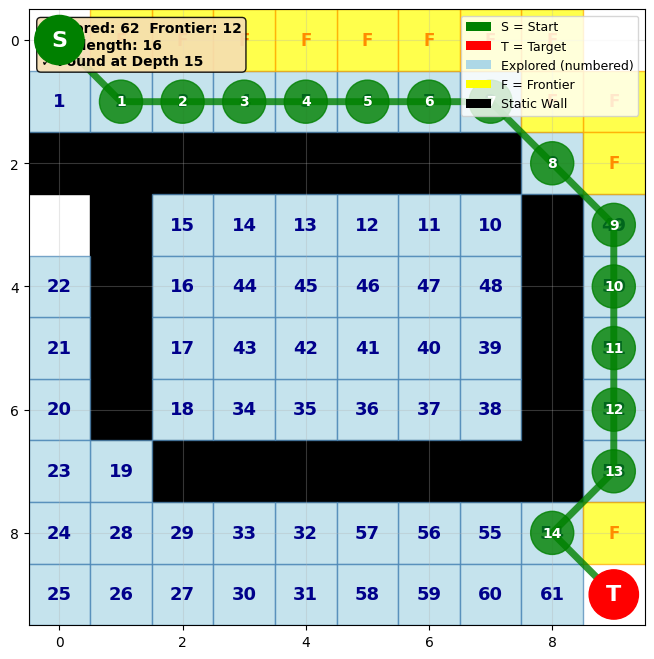

  ✓ Path found!
    Path length   : 16 nodes
    Nodes explored: 62
    Time          : 29.876s


<Figure size 640x480 with 0 Axes>


Run another? (press Enter to continue, or type 'exit' to quit):  



╔══════════════════════════════╗
║      SELECT ALGORITHM        ║
╠══════════════════════════════╣
║  1. BFS                      ║
║  2. DFS                      ║
║  3. UCS                      ║
║  4. DLS                      ║
║  5. IDDFS                    ║
║  6. Bidirectional Search     ║
║  7. Run ALL algorithms       ║
║  0. EXIT                     ║
╚══════════════════════════════╝


Enter choice (0-7):  0



Exiting. Goodbye!


In [15]:
# ─────────────────────────────────────────────
# INTERACTIVE SELECTOR 
# ─────────────────────────────────────────────

def run_selected():
    algo_map = {
        "1": ("BFS",           lambda s: s.bfs()),
        "2": ("DFS",           lambda s: s.dfs()),
        "3": ("UCS",           lambda s: s.ucs()),
        "4": ("DLS",           lambda s: s.dls(limit=20)),
        "5": ("IDDFS",         lambda s: s.iddfs(max_depth=20)),
        "6": ("Bidirectional", lambda s: s.bidirectional_search()),
        "7": ("ALL ALGORITHMS", None),
    }

    scenario_map = {
        "1": ("BEST CASE",    create_best_case_grid),
        "2": ("WORST CASE",   create_worst_case_grid),
        "3": ("DEFAULT GRID", create_sample_grid),
    }

    while True:
        # ── Algorithm menu ──
        print("\n╔══════════════════════════════╗")
        print("║      SELECT ALGORITHM        ║")
        print("╠══════════════════════════════╣")
        print("║  1. BFS                      ║")
        print("║  2. DFS                      ║")
        print("║  3. UCS                      ║")
        print("║  4. DLS                      ║")
        print("║  5. IDDFS                    ║")
        print("║  6. Bidirectional Search     ║")
        print("║  7. Run ALL algorithms       ║")
        print("║  0. EXIT                     ║")
        print("╚══════════════════════════════╝")

        algo_choice = input("Enter choice (0-7): ").strip()

        if algo_choice == "0":
            print("\nExiting. Goodbye!")
            break

        if algo_choice not in algo_map:
            print("Invalid choice. Try again.")
            continue

        # ── Scenario menu ──
        print("\n╔══════════════════════════════╗")
        print("║      SELECT SCENARIO         ║")
        print("╠══════════════════════════════╣")
        print("║  1. Best Case                ║")
        print("║  2. Worst Case               ║")
        print("║  3. Default Grid             ║")
        print("╚══════════════════════════════╝")

        scenario_choice = input("Enter choice (1-3): ").strip()

        if scenario_choice not in scenario_map:
            print("Invalid choice. Try again.")
            continue

        # ── Build run list ──
        if algo_choice == "7":
            algos_to_run = [(name, fn) for name, fn in [
                ("BFS",           lambda s: s.bfs()),
                ("DFS",           lambda s: s.dfs()),
                ("UCS",           lambda s: s.ucs()),
                ("DLS",           lambda s: s.dls(limit=20)),
                ("IDDFS",         lambda s: s.iddfs(max_depth=20)),
                ("Bidirectional", lambda s: s.bidirectional_search()),
            ]]
        else:
            algo_name, algo_fn = algo_map[algo_choice]
            algos_to_run = [(algo_name, algo_fn)]

        scenario_name, grid_fn = scenario_map[scenario_choice]

        # ── Run ──
        for algo_name, algo_fn in algos_to_run:
            print(f"\n{'='*50}")
            print(f"  {algo_name}  —  {scenario_name}")
            print(f"{'='*50}")

            env        = grid_fn()
            visualizer = PathfinderVisualizer(env)
            searcher   = UniformSearchAlgorithms(env, visualizer)

            start_time = time.time()
            path, nodes_explored = algo_fn(searcher)
            end_time   = time.time()

            if path:
                print(f"  ✓ Path found!")
                print(f"    Path length   : {len(path)} nodes")
                print(f"    Nodes explored: {nodes_explored}")
                print(f"    Time          : {end_time - start_time:.3f}s")
            else:
                print(f"  ✗ No path found")
                print(f"    Nodes explored: {nodes_explored}")

            plt.suptitle(f"{algo_name} — {scenario_name}",
                         fontsize=14, fontweight='bold', color='darkred')
            plt.show()

        # ── Ask again ──
        again = input("\nRun another? (press Enter to continue, or type 'exit' to quit): ").strip().lower()
        if again == "exit":
            print("\nGoodbye!")
            break

# ── Launch ──
run_selected()